In [1]:
%matplotlib inline
from sensor_data_analysis_api import *
from sklearn.metrics import mean_squared_error
import sys
import os

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

enablePrint()

### CLASS: piecewise_linear

**piecewise_linear is the class that performs the piecewise linear approximation on the data. **

1. This class inherits encoder class.
2. compress and recon are overridden from base class.
3. internal method fit() is used to fit the data.


**Constructor:**
- Takes input as series.
- Calls fit() to train the model.

**fit**
- Takes series of values and max_gap as input.
- Uses dynamic programming to create patches of minimized error.
- Error is calculated iteratively by finding the slope for each max_gap.
- values for minimum error is stored in each iteration.

**recon**

- Linear interpolation is performed for reconstruction from the compresseed data.
- numpy interpolation function is used.

**Compress**

- Iteratively stores the time and values for every changing slope

**Observations**

- As the map gap (used by piecewise linear) reduces the rmse reduces.

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_linear model initialized
error = 0.0163576210903 error/_std= 0.00505494767415


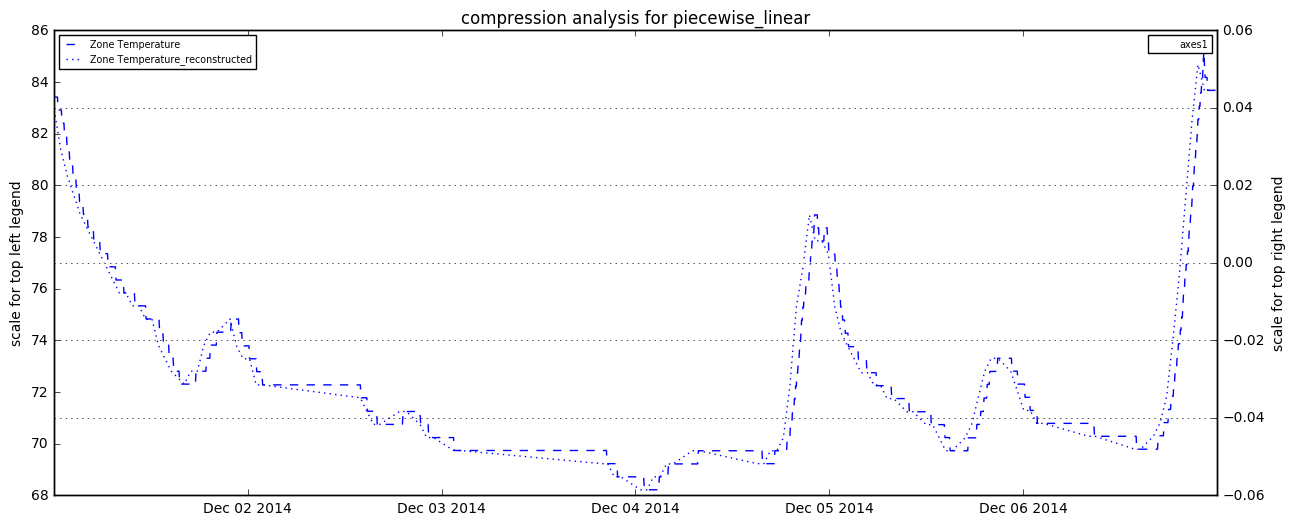

In [2]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method = 'piecewise_linear'
[dfs, plotTemplates, dfs_compressed] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals, method=method)
plotResults(dfs, plotTemplates, method = method)

### CLASS: piecewise_constant

**piecewise_linear is the class that performs the piecewise constant approximation on the data. **

1. This class inherits encoder class.
2. compress and recon are overridden from base class.
3. internal method fit() is used to fit the data.


**Constructor:**

- Takes input as series.
- Calls fit() to train the model.

**fit**

- Takes series of values and max_gap as input.
- Uses dynamic programming to create patches of minimized error.
- Error is calculated iteratively by finding the error and number of switches.
- values for minimum error is stored in each iteration.

**recon**

- Takes the array of time, value pairs and create a treashold points.
- NaNs are removed and are not interpolated to have constant values.

**Compress**

- Creates an array of {time, value} values based on the current and previous value.

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_constant model initialized
error = 0.00515153738704 error/_std= 0.00159196449099


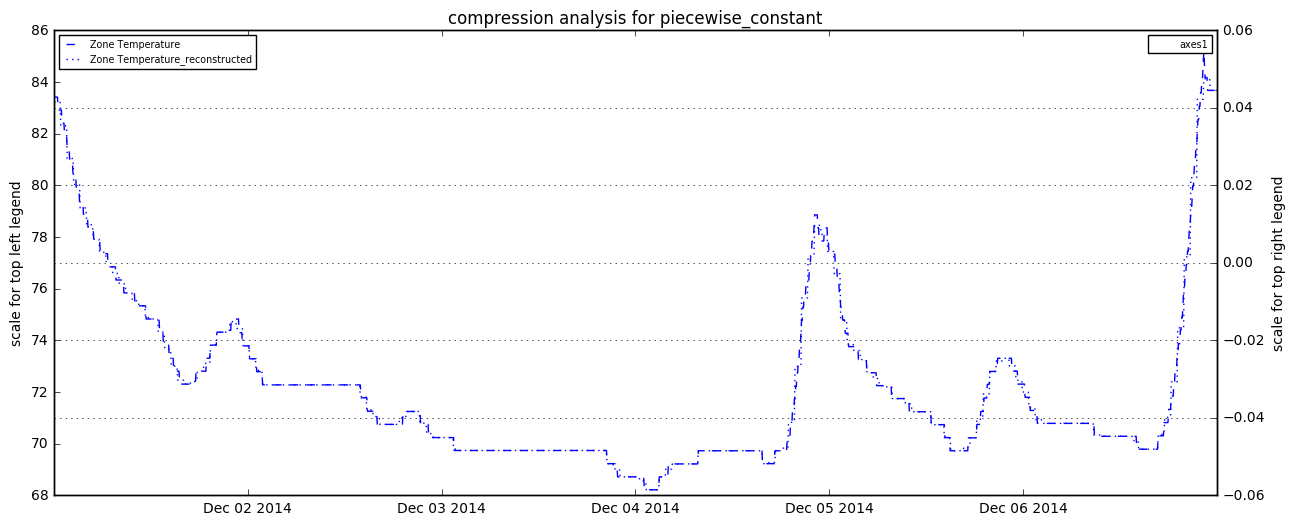

In [3]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method='piecewise_constant'
[dfs, plotTemplates, dfs_compressed] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals, method = method)
plotResults(dfs, plotTemplates, method=method)

### API: CompressWithPCA

**CompressWithPCA is the API that performs PCA on the data frame and plots the original and reconstructed for template.**

1. Takes the data frame as input
2. Performs PCA, transforms and reconstructs the data frame with the number of components specified
3. filters the data frame based on date range
4. selects the required template from original and reconstructed
5. returns the data frames

**Observations**

1. Though the 95% of variance is explained with only 4 major components, the Zone temperature and supplt air flow has optimal reconstruction with 9 components

In [ ]:
room = 'Rm-4226'
dataDF = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)

In [ ]:
n_components = 9
[dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime='2014-12-01', enTime='2014-12-07', n_components = 9)
plotResults(dfs, plotTemplates, method='pca with %d components'%n_components)

### API for running multiple models on several rooms and signals

- Takes in rooms, signals, start time and end time
- Runs piecewise linear, piecewise constant, PCA with 4, 7 and 9 components
- calculates the RMSE of original and reconstructed signals.

In [4]:
def AnalyzeModels(rooms, signals, stTime, enTime):
    df_list = []
    
    for room in rooms:
        dataDF = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)
        for signal in signals:
            # piece wise linear
            method = 'piecewise_linear'
            [dfs, plotTemplates, dfs_compressed] = runAnalysis(room, stTime, enTime, templates = [signal], method = method)
            rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
            d = {
                 'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                 'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
                 'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
                }
            df_list.append(pd.DataFrame(d, index=[0]))

            # piecewise constant
            method = 'piecewise_constant'
            [dfs, plotTemplates, dfs_compressed] = runAnalysis(room, stTime, enTime, templates = [signal], method = method)
            rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
            d = {
                 'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                 'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
                 'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
                }
            df_list.append(pd.DataFrame(d, index=[0]))

            # PCA
            n_components = 9
            method = 'PCA_%d'%n_components
            [dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime, enTime, n_components = n_components)
            rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
            d = {
                'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                'original_size' : dataDF.memory_usage().sum() - dataDF.memory_usage()['Index'],
                'compressed_size' : compressed[0].nbytes
            }
            df_list.append(pd.DataFrame(d, index=[0]))

            # PCA
            n_components = 7
            method = 'PCA_%d'%n_components
            [dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime, enTime, n_components = n_components)
            rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
            d = {
                'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                'original_size' : dataDF.memory_usage().sum() - dataDF.memory_usage()['Index'],
                'compressed_size' : compressed[0].nbytes
            }
            df_list.append(pd.DataFrame(d, index=[0]))

            # PCA
            n_components = 4
            method = 'PCA_%d'%n_components
            [dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime, enTime, n_components = n_components)
            rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
            d = {
                'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                'original_size' : dataDF.memory_usage().sum() - dataDF.memory_usage()['Index'],
                'compressed_size' : compressed[0].nbytes
            }
            df_list.append(pd.DataFrame(d, index=[0]))

    return pd.concat(df_list, ignore_index=True)

In [62]:
#rooms = ['Rm-4226']
rooms = ['Rm-4226', 'Rm-3114']
signals = ['Zone Temperature', 'Supply Airflow']
df_result = AnalyzeModels(rooms, signals, stTime='2014-12-01', enTime='2014-12-07')

Read file:  506_0_3001981.csv
Read file:  506_0_3001987.csv
Read file:  506_0_3001985.csv
Read file:  506_0_3001984.csv
Read file:  506_0_3001986.csv
Read file:  506_1_3001989.csv
Read file:  506_1_3015755.csv
Read file:  506_1_3001991.csv
Read file:  506_1_3001988.csv
Read file:  506_1_3001994.csv
Read file:  506_1_3001993.csv
Read file:  506_1_3001996.csv
Read file:  506_1_3001990.csv
Read file:  506_1_3001992.csv
Read file:  506_1_3001995.csv
Read file:  506_14_3001999.csv
Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_linear model initialized
error = 0.0163576210903 error/_std= 0.00505494767415
Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_constant model initialized
error = 0.00515153738704 error/_std= 0.00159196449099
Read file:  506_0_3001987.csv
Std dev is  213.591508212
Fitting piecewise_constant
range =  989.95
piecewise_linear model initialized
error = 1.

### Results of piecewise linear, piece wise constant, PCA for rooms 4226 and 3114

- RMSE for piecewise linear for supply airflow is higher because of larger range of values and non standardisation
- For room 4226, 9 components explain the Zone temperature and Supply airflow.
- But for room 3114, even 4 components the RMSE is lesser.

In [32]:
color_map = {'piecewise_linear' : 'red', 'piecewise_constant' : 'green', 'PCA_9' : 'blue',
             'PCA_7' : 'orange', 'PCA_4' : 'violet'}

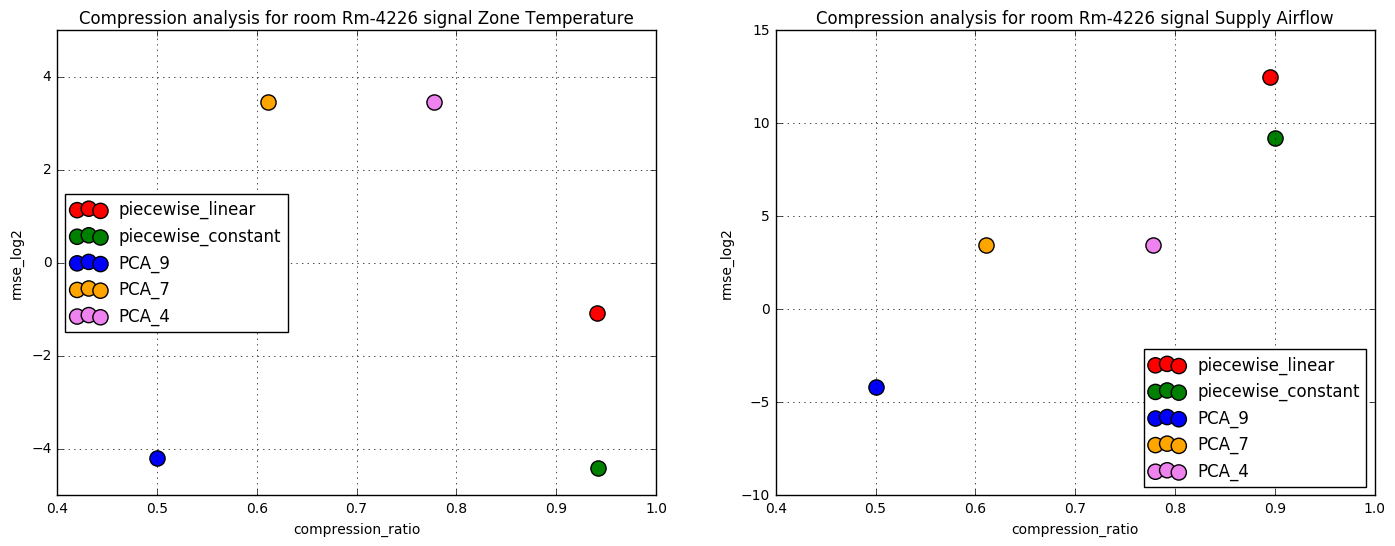

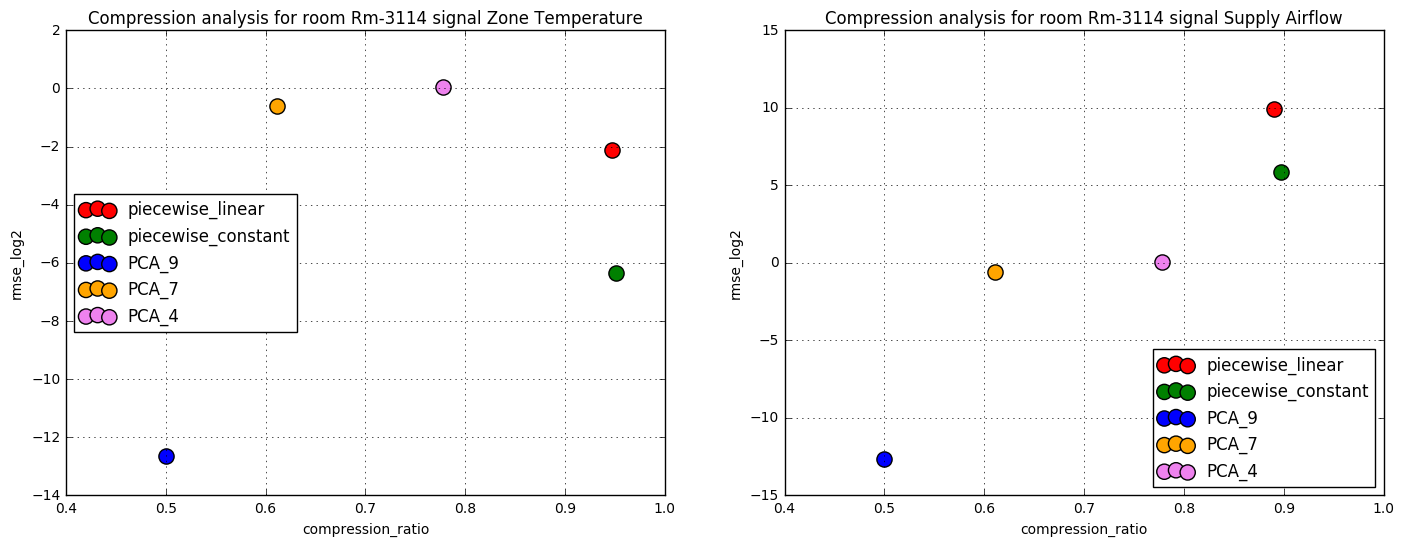

In [64]:
df_result['compression_ratio'] = (df_result.original_size - df_result.compressed_size) / df_result.original_size
df_result['rmse_log'] = np.log2(df_result.rmse)

for room in df_result.room.unique():
    fig, axs = plt.subplots(1, 2, figsize=(17, 6))
    for ax, signal in zip(axs, df_result.signal.unique()):
        ax.set_title('Compression analysis for room %s signal %s'%(room, signal))
        ax.set_xlabel('compression_ratio')
        ax.set_ylabel('rmse_log2')
        ax.grid(True)
        for model in df_result.model.unique():
            x = df_result[(df_result.signal == signal) & (df_result.model == model) & (df_result.room == room)].compression_ratio
            y = df_result[(df_result.signal == signal) & (df_result.model == model) & (df_result.room == room)].rmse_log
            ax.scatter(x, y, c=color_map[model], s=120, label=model)

    axs[0].legend(loc='center left')
    axs[1].legend(loc='lower right')